In [1]:
import numpy as np
import pandas as pd
from viz import show_field


In [2]:
df = pd.read_csv('resources/train.csv', index_col='id')
sample = df[df.delta == 3].sample(random_state=42)
X, Y = sample.values[:, 1:401].reshape((20, 20)), sample.values[:, 401:].reshape((20, 20))

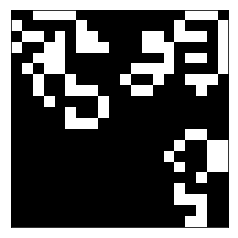

In [3]:
show_field(Y)

In [9]:
M = ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))
NROW = NCOL = 20

def calc_neighs(field, i, j):
    neighs = 0
    n = len(field)
    for m in M:
        row_idx = m[0] + i
        col_idx = m[1] + j
        if 0 <= row_idx < n and 0 <= col_idx < n:
            if field[row_idx][col_idx]:
                neighs += 1
    return neighs

def old_make_move(field, moves=1):
    n = len(field)
    cur_field = field
    for _ in range(moves):
        new_field = np.zeros((n, n), dtype='uint8')
        for i in range(n):
            for j in range(n):
                neighs = calc_neighs(cur_field, i, j)
                if cur_field[i][j] and neighs == 2:
                    new_field[i][j] = 1
                if neighs == 3:
                    new_field[i][j] = 1
        cur_field = new_field
    return cur_field


In [10]:
import cython

In [11]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [224]:
%%cython -a
import numpy as np
cimport numpy as cnp

cdef int calc_neighs(unsigned char[:, :] field, int i, int j, int n):
    cdef:
        int neighs = 0;
        int k, row_idx, col_idx;
    neighs = 0
    if i - 1 >= 0 and j - 1 >= 0 and field[i - 1, j - 1]:
        neighs += 1
    if i - 1 >= 0 and field[i - 1, j]:
        neighs += 1
    if i - 1 >= 0 and j + 1 < n and field[i - 1, j + 1]:
        neighs += 1
    if j - 1 >= 0 and field[i, j - 1]:
        neighs += 1
    if j + 1 < n and field[i, j + 1]:
        neighs += 1
    if i + 1 < n and j - 1 >= 0 and field[i + 1, j - 1]:
        neighs += 1
    if i + 1 < n and field[i + 1, j]:
        neighs += 1
    if i + 1 < n and j + 1 < n and field[i + 1, j + 1]:
        neighs += 1
    return neighs


cpdef make_move(unsigned char[:, :] field, int moves):
    cdef:
        int _, i, j, neighs;
        int n;
        int switch = 0;
        unsigned char[:, :] cur_field;
        unsigned char[:, :] next_field;
    cur_field = np.copy(field)
    next_field = np.zeros_like(field, 'uint8')
    n = len(field)
    for _ in range(moves):
        if switch == 0:
            for i in range(n):
                for j in range(n):
                    neighs = calc_neighs(cur_field, i, j, n)
                    if cur_field[i, j] and neighs == 2:
                        next_field[i, j] = 1
                    elif neighs == 3:
                        next_field[i, j] = 1
                    else:
                        next_field[i, j] = 0
        else:
            for i in range(n):
                for j in range(n):
                    neighs = calc_neighs(next_field, i, j, n)
                    if next_field[i, j] and neighs == 2:
                        cur_field[i, j] = 1
                    elif neighs == 3:
                        cur_field[i, j] = 1
                    else:
                        cur_field[i, j] = 0
        switch = (switch + 1) % 2
    return np.array(next_field if switch else cur_field)

In [24]:
make_move(X, 1)

array([[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [174]:
A = np.zeros((20, 20), 'uint8')

In [175]:
A[8, 8] = 1
A[9, 9] = 1
A[7:10, 10] = 1

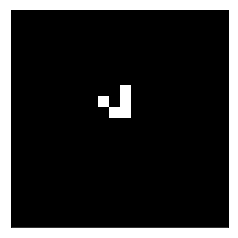

In [157]:
show_field(A)

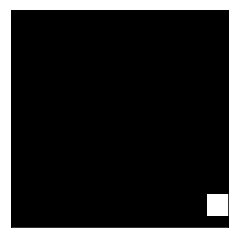

In [181]:
show_field(make_move(A, 100000))

In [195]:
A = np.random.binomial(1, 0.5, (100, 100)).astype('uint8')

In [197]:
%%timeit
make_move(A, 100)

34.2 ms ± 673 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [191]:
from tools import make_move

In [193]:
%%timeit
make_move(A, 100)

4.79 s ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
